In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15173884834447684046,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2258055988
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16320901701901498889
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"]

In [3]:
train_path='D:\DUmDum\deepfakes\dataset\Train'
valid_path='D:\DUmDum\deepfakes\dataset\Validation'
test_path='D:\DUmDum\deepfakes\dataset\Test'

In [4]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
                .flow_from_directory(directory=train_path, target_size=(224,224),classes=['Fake','Real'],batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
                .flow_from_directory(directory=valid_path, target_size=(224,224),classes=['Fake','Real'],batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
                .flow_from_directory(directory=test_path, target_size=(224,224),classes=['Fake','Real'],batch_size=10)


Found 140002 images belonging to 2 classes.
Found 39428 images belonging to 2 classes.
Found 10905 images belonging to 2 classes.


In [5]:
assert train_batches.n == 140002
assert valid_batches.n == 39428
assert test_batches.n == 10905
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

In [6]:
train_batches.classes


array([0, 0, 0, ..., 1, 1, 1])

In [7]:
imgs, labels =next(train_batches)

In [8]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1,10,figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

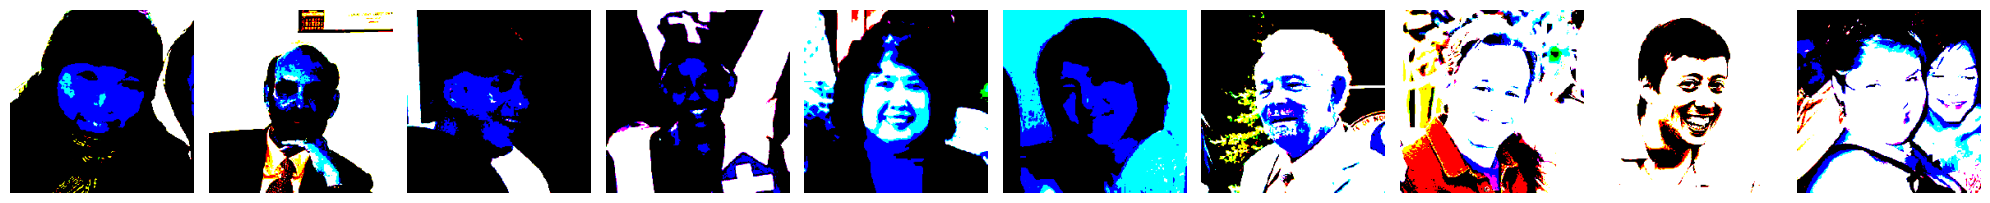

[[0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [9]:
plotImages(imgs)
print(labels)

In [10]:
model = Sequential([
        Conv2D(filters=16, kernel_size=(3,3),activation='relu',padding='same',input_shape=(224,224,3)),
        MaxPool2D(pool_size=(2,2),strides = 2),
        Conv2D(filters=32, kernel_size=(3,3), activation = 'relu' , padding = 'same'),
        MaxPool2D(pool_size=(2,2),strides=2 ),
        Conv2D(filters=64, kernel_size=(3,3), activation = 'relu' , padding = 'same'),
        MaxPool2D(pool_size=(2,2),strides=2 ),
        Flatten(),
        Dense(units=2, activation='softmax'), 
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0

In [12]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [13]:
from tensorflow.python.client import device_lib
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [14]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9639217616130669501,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2258055988
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12860233356020054053
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"]

In [15]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [16]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [17]:
history = model.fit(x=train_batches,validation_data=valid_batches,epochs=10,verbose=1)

Epoch 1/10
14001/14001 [==============================] - 1560s 111ms/step - loss: 0.3745 - accuracy: 0.8565 - val_loss: 0.3003 - val_accuracy: 0.8754
Epoch 2/10
14001/14001 [==============================] - 1492s 107ms/step - loss: 0.1684 - accuracy: 0.9319 - val_loss: 0.3018 - val_accuracy: 0.8792
Epoch 3/10
14001/14001 [==============================] - 1409s 101ms/step - loss: 0.1226 - accuracy: 0.9511 - val_loss: 0.2990 - val_accuracy: 0.8948
Epoch 4/10
14001/14001 [==============================] - 1424s 102ms/step - loss: 0.0941 - accuracy: 0.9622 - val_loss: 0.2979 - val_accuracy: 0.9024
Epoch 5/10
14001/14001 [==============================] - 1421s 101ms/step - loss: 0.0764 - accuracy: 0.9703 - val_loss: 0.3339 - val_accuracy: 0.9048
Epoch 6/10
14001/14001 [==============================] - 1394s 100ms/step - loss: 0.0624 - accuracy: 0.9756 - val_loss: 0.3602 - val_accuracy: 0.9050
Epoch 7/10
14001/14001 [==============================] - 1447s 103ms/step - loss: 0.0548 - ac

In [18]:
test_batches.classes

array([0, 0, 0, ..., 1, 1, 1])

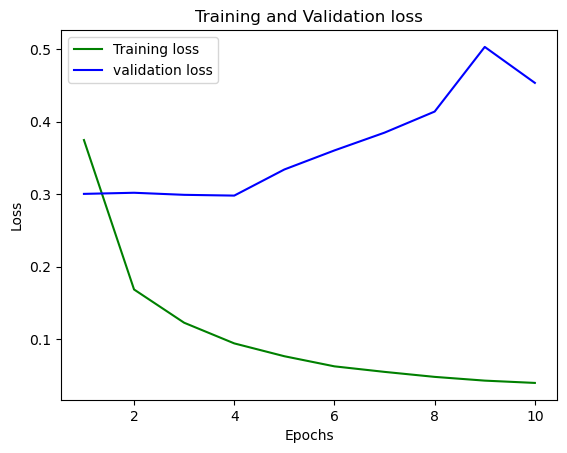

In [21]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,11)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

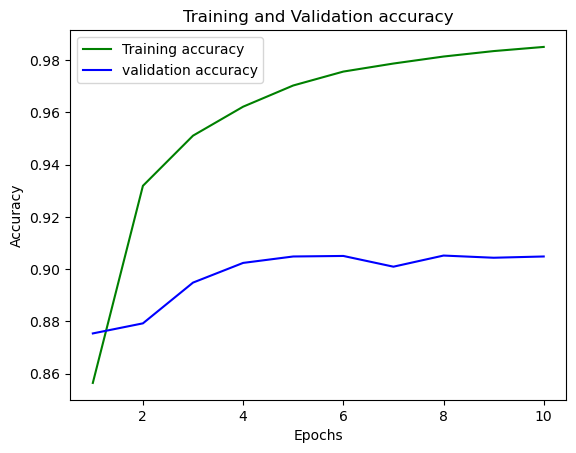

In [23]:
loss = history.history['accuracy']
val_loss = history.history['val_accuracy']
epochs = range(1,11)
plt.plot(epochs, loss, 'g', label='Training accuracy')
plt.plot(epochs, val_loss, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [24]:
predictions = model.predict(x=test_batches,verbose=1)

1091/1091 [==============================] - 97s 89ms/step


In [25]:
np.round(predictions)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [26]:
cm=confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions,axis=-1))

In [27]:
def plot_confusion_matrix(cm,classes,
                          normalize=False,
                          title='confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation =45)
    plt.yticks(tick_marks,classes)
    
    if normalize:
        cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion Matrix")
    else:
        print("Confusion Matrix,without normalization")
        
    print(cm)
    
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j]),
        horizontalalignment="center",
        color="white" if cm[i,j]>thresh else "black"
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
            


In [28]:
test_batches.class_indices

{'Fake': 0, 'Real': 1}

Confusion Matrix,without normalization
[[3177 2315]
 [3091 2322]]


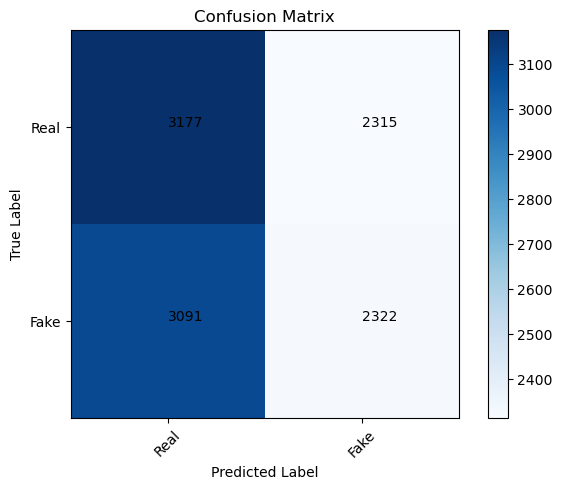

In [29]:
cm_plot_labels=['Real','Fake']
plot_confusion_matrix(cm=cm,classes=cm_plot_labels,title='Confusion Matrix')

In [30]:
#import os.path
#if os.path.isfile('D:\DUmDum\deepfakes\DFmodel\df.h5') is False:
    #model.save('D:\DUmDum\deepfakes\DFmodel\df2.h5')

NameError: name 'test_batches' is not defined